# Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import os

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

tick_major = 6
tick_minor = 4
plt.rcParams["xtick.major.size"] = tick_major
plt.rcParams["xtick.minor.size"] = tick_minor
plt.rcParams["ytick.major.size"] = tick_major
plt.rcParams["ytick.minor.size"] = tick_minor

font_small = 12
font_medium = 13
font_large = 14
plt.rc('font', size=font_small)          # controls default text sizes
plt.rc('axes', titlesize=font_medium)    # fontsize of the axes title
plt.rc('axes', labelsize=font_medium)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_small)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_small)    # legend fontsize
plt.rc('figure', titlesize=font_large)   # fontsize of the figure title

import matplotlib.colors as clr

# Model Controls

## Loading the Model

In [2]:
from neuron import h
h.load_file("runModel.hoc")

	1 
	1 
Setting temperature to 34.000000 C
Setting simulation time step to 0.100000 ms
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
**********************
cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0]
1 
1 
1 
	1 
	1 
	1 


1.0

## Initialize Model Params

In [4]:
def init_settings(nav12=1,
                  nav16=1,
                  dend_nav12=1, 
                  soma_nav12=1, 
                  ais_nav12=1, 
                  dend_nav16=1, 
                  soma_nav16=1,
                  ais_nav16=1, 
                  axon_Kp=1,
                  axon_Kt =1,
                  axon_K=1,
                  soma_K=1,
                  dend_K=1,
                  gpas_all=1,
                  hcn=1):
    
    # create default model parameters to avoid loading the model
    
    h.dend_na12 = 0.026145/2 
    h.dend_na16 = h.dend_na12 
    h.dend_k = 0.004226 * soma_K


    h.soma_na12 = 0.983955/10 
    h.soma_na16 = h.soma_na12 
    h.soma_K = 0.303472 * soma_K

    h.ais_na16 = 4 
    h.ais_na12 = 4 
    h.ais_ca = 0.000990
    h.ais_KCa = 0.007104

    h.node_na = 2

    h.axon_KP = 0.973538 * axon_Kp
    h.axon_KT = 0.089259 * axon_Kt
    h.axon_K = 1.021945 * axon_K

    h.cell.axon[0].gCa_LVAstbar_Ca_LVAst = 0.001376286159287454
    
    #h.soma_na12 = h.soma_na12/2
    h.naked_axon_na = h.soma_na16/5
    h.navshift = -10
    h.myelin_na = h.naked_axon_na
    h.myelin_K = 0.303472
    h.myelin_scale = 10
    h.gpas_all = 3e-5 * gpas_all
    h.cm_all = 1
    
    
    h.dend_na12 = h.dend_na12 * nav12 * dend_nav12
    h.soma_na12 = h.soma_na12 * nav12 * soma_nav12
    h.ais_na12 = h.ais_na12 * nav12 * ais_nav12
    
    h.dend_na16 = h.dend_na16 * nav16 * dend_nav16
    h.soma_na16 = h.soma_na16 * nav16 * soma_nav16
    h.ais_na16 = h.ais_na16 * nav16 * ais_nav16
    
    h.hcn = hcn
    
#     h.km = km
    
    h.working()

## Initialize Stimulation Params

In [5]:
def init_stim(sweep_len = 800, stim_start = 100, stim_dur = 500, amp = 0.5, dt = 0.01):
    # updates the stimulation params used by the model
    # time values are in ms
    # amp values are in nA
    
    h("st.del = " + str(stim_start))
    h("st.dur = " + str(stim_dur))
    h("st.amp = " + str(amp))
    h.tstop = sweep_len
    h.dt = dt

## Run the model

In [6]:
def run_model(start_Vm = -72):

    h.finitialize(start_Vm)
    timesteps = int(h.tstop/h.dt)
    
    Vm = np.zeros(timesteps)
    I = {}
    I['Na'] = np.zeros(timesteps)
    I['Ca'] = np.zeros(timesteps)
    I['K'] = np.zeros(timesteps)
    t = np.zeros(timesteps)
    
    for i in range(timesteps):
        Vm[i] = h.cell.soma[0].v
        I['Na'][i] = h.cell.soma[0](0.5).ina
        I['Ca'][i] = h.cell.soma[0](0.5).ica
        I['K'][i] = h.cell.soma[0](0.5).ik
        t[i] = i*h.dt / 1000
        h.fadvance()
        
    return Vm, I, t

## AP analysis code

In [7]:
def detect_spikes(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002, properties=True):
    '''
    Method for idenifying spikes based on rates of change in the membrane potential
    INPUTS:
    Vm: array-like - membrane potential (mV)
    time: array-like - time corresponding to Vm (sec)
    dVdt_thresh: float - Threshold for determining spike initiation (V/s)
    min_spike_len: float - Minimum length of time dVdt must be above dVdt_thresh to be considered a spike (sec)
    properties: Bool - If true, returns spike_times and spike_properties. Otherwise returns only spike_properties

    Output:
    array of spike times

    Identification of spike start times:
    dVdt is first quanitified from Vm and time
    Continuous tretches (runs) of dVdt above dVdt_thresh are identified, and then esured to last longer than min_spike_len

    Spike Property measurement:
    spike_end is determined by finding the second zero crossing of dVdt after spike dVdt_threshold
    First zero crossing is AP peak, second should be end of repolarization phase
    Persistent zero crossing (must stay above zero for 3 continous points) is used to make sure that noise in slowly repolarizing spikes doesn't trigger spike end
    '''
    if len(Vm) != len(time):
        raise Exception("Vm and time must be the same length")

    #determine stretches where dVdt exceeds dVdt_thresh
    dVdt = np.gradient(Vm,time)/1e3
    runs = group_consecutives(np.argwhere((dVdt>=dVdt_thresh)).flatten())

    #If runs are longer than min_spike_len count as a spike
    dt = time[1]-time[0] #sample rate
    min_run_len = np.ceil(min_spike_len/dt)
    spike_times = []
    for run in runs:
        if len(run) > min_run_len:
            spike_times.append(time[run[0]])
    spike_times = np.asarray(spike_times)

    if not properties: #just return spike_times
        return spike_times

    #get spike properties
    spike_properties=[]
    for spike_time in spike_times:
        #find index of spike_time in time
        spike_start_idx = np.argwhere(spike_time == time)[0][0]

        #find zero crossings of dVdt after spike dVdt_threshold
        zero_crosses = find_zero_crossing(dVdt[spike_start_idx:-1])
        #make sure zero cross is persistent to account for noise
        if len(zero_crosses) > 1:
            spike_end_idx = spike_start_idx\
                            + zero_crosses[np.argwhere(np.diff(zero_crosses)>3)[0] + 1][0]
        else: #Vm ends before spike can repolarize, therefore assigned Vm[-1] as spike end
            spike_end_idx = len(Vm)-1

        spike_Vm = Vm[spike_start_idx:spike_end_idx]
        spike_time = time[spike_start_idx:spike_end_idx] - time[spike_start_idx]
        spike_dVdt = dVdt[spike_start_idx:spike_end_idx]
        spike = {}
        spike['start_idx'] = spike_start_idx
        spike['start_time'] = time[spike_start_idx]
        spike['end_idx'] = spike_end_idx
        spike['end_time'] = time[spike_end_idx]
        spike['Vm'] = spike_Vm
        spike['time'] = spike_time
        spike['thresh'] = spike_Vm[0]
        spike['peak_Vm'] = spike_Vm.max()
        spike['height'] = np.max(spike_Vm)-spike_Vm[0]
        spike['AHP'] = spike_Vm[0]-spike_Vm[-1]
        spike['peak_dVdt'] = spike_dVdt.max()
        spike['min_dVdt'] = spike_dVdt.min()
        try:
            half_pnts = find_zero_crossing(spike_Vm - (spike_Vm[0]+(np.max(spike_Vm)-spike_Vm[0])/2))
            spike['half_width'] = (half_pnts[1]-half_pnts[0])*dt*1000
        except: #For slowly repolarizing spikes this can sometimes fail
            spike['half_width'] = np.nan

        spike_properties.append(spike)
    return spike_times,spike_properties

def detect_spike_times(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0002):
    '''
    Wrapper of detect_spikes to only get spike times
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=False)

def detect_spike_properties(Vm, time, dVdt_thresh = 15, min_spike_len = 0.0001):
    '''
    Wrapper of detect_spikes to only get spike properties
    '''
    return detect_spikes(Vm, time,
                          dVdt_thresh = dVdt_thresh,
                          min_spike_len = min_spike_len,
                          properties=True)[1]

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list)."""
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result

def find_zero_crossing(x):
    '''
    returns array of indicies before a zero crossing occur
    If your input array starts and stops with zeros, it will find a zero crossing at the beginning, but not at the end
    '''
    zero_crossings = np.where(np.diff(np.signbit(x)))[0]
    return zero_crossings

## FI Curve support functions

In [8]:
def FI_curve(stims, iclamp, orig, iclamp_amp, stim_start = 50, stim_dur = 300, sweep_len = 350, dt = 0.1):
             
    f = []
    i = []
    for amp in stims:
        i.append(amp)
        init_stim(stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len, dt=dt, amp=amp)
        iclamp.amp = iclamp_amp if orig is False else 0
        
        Vm, I, t = run_model()
        spike_times = detect_spike_times(Vm, t)
        f.append(len(spike_times))
    
    return f, i

def FI_curve_plot(stims, iclamp, orig, iclamp_amp, ax, label='', stim_start = 50, stim_dur = 300, sweep_len = 350, dt = 0.5):
    f, i = FI_curve(stims=stims, iclamp=iclamp, orig=orig, iclamp_amp=iclamp_amp, stim_start=stim_start, stim_dur=stim_dur, sweep_len=sweep_len, dt=dt)
    
    ax.set_ylim(0,12)
    ax.set_ylabel('Spikes per Epoch ({}ms)'.format(stim_dur))
    ax.set_xlabel('Injected Current (nA)')
    ax.plot(i, f, linewidth = 1, label=label) 


# 25% Ri Increase (Gpas = 0)

In [9]:
plot_path = './ri increase_figures/'
# if os.path.isdir(plot_path) is False:
#     os.mkdir(plot_path)

In [10]:
gpas_reduct = 0
hcn_reduct = 0.52
iclamp_amp = 0.0234

## 1. FI Curves

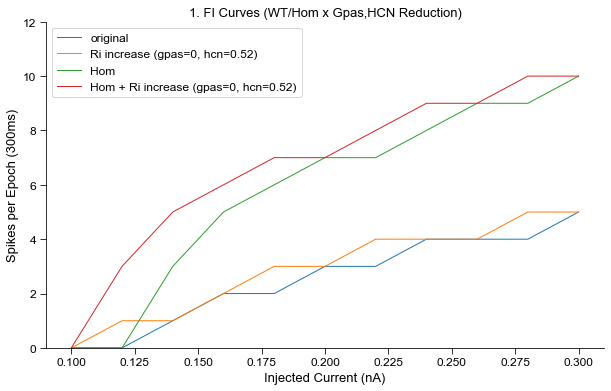

In [11]:
fig,ax = plt.subplots(figsize=(10,6))
stims = np.arange(0.1,.31,.02)

iclamp = h.IClamp(h.cell.soma[0](0.5))
iclamp.delay = 300
iclamp.dur = 900

stim_start = 600
stim_dur = 300
sweep_len = 950
dt = 0.2

init_settings()
FI_curve_plot(stims=stims, iclamp=iclamp, orig=True, iclamp_amp=iclamp_amp, ax=ax, label='original', stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(gpas_all=gpas_reduct, hcn=hcn_reduct)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=False, iclamp_amp=iclamp_amp, ax=ax, label='Ri increase (gpas=0, hcn=%.2f)'%(hcn_reduct), stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(nav12=0)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=True, iclamp_amp=iclamp_amp, ax=ax, label='Hom', stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(nav12=0, gpas_all=gpas_reduct, hcn=hcn_reduct)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=False, iclamp_amp=iclamp_amp, ax=ax, label='Hom + Ri increase (gpas=0, hcn=%.2f)'%(hcn_reduct), stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

plt.legend()
plt.title('1. FI Curves (WT/Hom x Gpas,HCN Reduction)')
# plt.savefig(plot_path+'fig_1_fi_curves.pdf')
plt.show()

## 2. Example Traces

original: 82 MOhm
Ri increase: 104 MOhm
82.87821389708057 104.22053166903765 25.751420992807954
diff: 21 MOhm (25%)


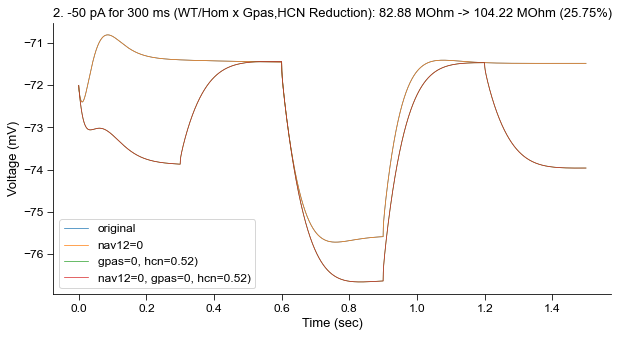

In [12]:
step_amp = -0.05
init_stim(stim_start=600, stim_dur=300, sweep_len=1500, dt=0.2, amp=step_amp)

iclamp = h.IClamp(h.cell.soma[0](0.5))
iclamp.delay = 300
iclamp.dur = 900

iclamp.amp = 0
init_settings()
Vm, I, t = run_model()
plt.figure(figsize=(10, 5))
plt.plot(t, Vm, lw=0.7, label='original')
start = int(0.6/0.2e-3)
end = int(0.9/0.2e-3)
original_ri = (Vm[end]-Vm[start])/step_amp
original_title = 'original: %d MOhm' %(np.round(original_ri, 2))
print(original_title)

iclamp.amp = 0
init_settings(nav12=0)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='nav12=0')
start = int(0.6/0.2e-3)
end = int(0.9/0.2e-3)
# original_ri = (Vm[end]-Vm[start])/step_amp
# original_title = 'original: %d MOhm' %(np.round(original_ri, 2))
# print(original_title)


iclamp.amp = iclamp_amp
init_settings(gpas_all=gpas_reduct, hcn=hcn_reduct)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='gpas=0, hcn=%.2f)'%(hcn_reduct))
gpas0_ri = (Vm[end]-Vm[start])/step_amp
gpas0_title = 'Ri increase: %d MOhm' %(np.round(gpas0_ri, 2))
print(gpas0_title)
diff_ri = gpas0_ri-original_ri
print(original_ri, gpas0_ri, diff_ri/original_ri*100)
diff_title = 'diff: %d MOhm (%d%%)' % (np.round(diff_ri, 2), np.round(diff_ri/original_ri*100, 2))
print(diff_title)

iclamp.amp = iclamp_amp
init_settings(nav12=0, gpas_all=gpas_reduct, hcn=hcn_reduct)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='nav12=0, gpas=0, hcn=%.2f)'%(hcn_reduct))

plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend()
n50pa_step_title = '2. -50 pA for 300 ms (WT/Hom x Gpas,HCN Reduction): %.2f MOhm -> %.2f MOhm (%.2f%%)' %(original_ri, gpas0_ri, np.round(diff_ri/original_ri*100, 2))
plt.title(n50pa_step_title)
# plt.savefig(plot_path+'fig_2_n50pa_step.pdf')
plt.show()

# 25% Ri Increase (Gpas = 1)

In [13]:
hcn_reduct = 0.5
iclamp_amp = 0.0294

## 3. FI Curves

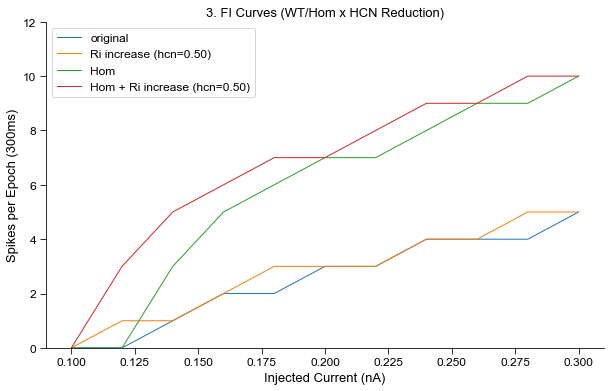

In [15]:
fig,ax = plt.subplots(figsize=(10,6))
stims = np.arange(0.1,.31,.02)

iclamp = h.IClamp(h.cell.soma[0](0.5))
iclamp.delay = 300
iclamp.dur = 900

stim_start = 600
stim_dur = 300
sweep_len = 950
dt = 0.2

init_settings()
FI_curve_plot(stims=stims, iclamp=iclamp, orig=True, iclamp_amp=iclamp_amp, ax=ax, label='original', stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(hcn=hcn_reduct)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=False, iclamp_amp=iclamp_amp, ax=ax, label='Ri increase (hcn=%.2f)'%(hcn_reduct), stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(nav12=0)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=True, iclamp_amp=iclamp_amp, ax=ax, label='Hom', stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

init_settings(nav12=0, hcn=hcn_reduct)
FI_curve_plot(stims=stims, iclamp=iclamp, orig=False, iclamp_amp=iclamp_amp, ax=ax, label='Hom + Ri increase (hcn=%.2f)'%(hcn_reduct), stim_start = stim_start, stim_dur = stim_dur, sweep_len = sweep_len, dt = dt)

plt.legend()
plt.title('3. FI Curves (WT/Hom x HCN Reduction)')
# plt.savefig(plot_path+'fig_3_fi_curves.pdf')
plt.show()

## 4. Example Traces

original: 82 MOhm
Ri increase: 103 MOhm
82.87821389708057 103.74363062720676 25.17599710345734
diff: 20 MOhm (25%)


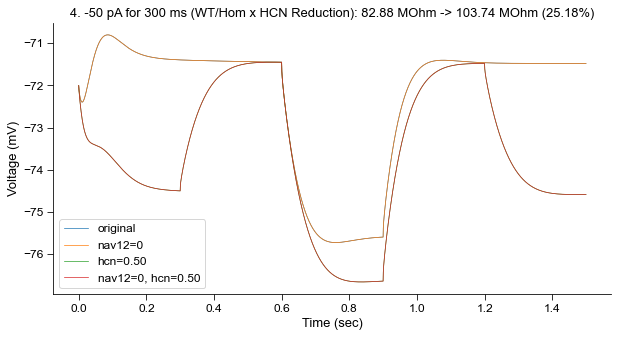

In [16]:
step_amp = -0.05
init_stim(stim_start=600, stim_dur=300, sweep_len=1500, dt=0.2, amp=step_amp)

iclamp = h.IClamp(h.cell.soma[0](0.5))
iclamp.delay = 300
iclamp.dur = 900

iclamp.amp = 0
init_settings()
Vm, I, t = run_model()
plt.figure(figsize=(10, 5))
plt.plot(t, Vm, lw=0.7, label='original')
start = int(0.6/0.2e-3)
end = int(0.9/0.2e-3)
original_ri = (Vm[end]-Vm[start])/step_amp
original_title = 'original: %d MOhm' %(np.round(original_ri, 2))
print(original_title)

iclamp.amp = 0
init_settings(nav12=0)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='nav12=0')


iclamp.amp = iclamp_amp
init_settings(hcn=hcn_reduct)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='hcn=%.2f'%(hcn_reduct))
gpas0_ri = (Vm[end]-Vm[start])/step_amp
gpas0_title = 'Ri increase: %d MOhm' %(np.round(gpas0_ri, 2))
print(gpas0_title)
diff_ri = gpas0_ri-original_ri
print(original_ri, gpas0_ri, diff_ri/original_ri*100)
diff_title = 'diff: %d MOhm (%d%%)' % (np.round(diff_ri, 2), np.round(diff_ri/original_ri*100, 2))
print(diff_title)

iclamp.amp = iclamp_amp
init_settings(nav12=0, hcn=hcn_reduct)
Vm, I, t = run_model()
plt.plot(t, Vm, lw=0.7, label='nav12=0, hcn=%.2f'%(hcn_reduct))

plt.xlabel('Time (sec)')
plt.ylabel('Voltage (mV)')
plt.legend()
n50pa_step_title = '4. -50 pA for 300 ms (WT/Hom x HCN Reduction): %.2f MOhm -> %.2f MOhm (%.2f%%)' %(original_ri, gpas0_ri, np.round(diff_ri/original_ri*100, 2))
plt.title(n50pa_step_title)
# plt.savefig(plot_path+'fig_4_n50pa_step.pdf')
plt.show()